# <span style="color:red"> ***** </span><span style="color:blue"> Power Normalized Cepstral Coefficients (PNCC)</span> <span style="color:green"> ***** </span>

Power Normalized Cepstral Coefficients (PNCC) is an advanced feature extraction technique used in speech processing, particularly for robust speech recognition. Here's an overview of PNCC in speech extraction:
Purpose: PNCC aims to improve speech recognition accuracy, especially in noisy environments or with reverberant speech.
Advantages over MFCC: PNCC generally outperforms traditional Mel-Frequency Cepstral Coefficients (MFCC) in challenging acoustic conditions.

Key components:

Power-law nonlinearity

Noise suppression mechanism

Temporal masking

Medium-time power analysis

Frequency smoothing

Noise robustness: PNCC is designed to be more resilient to various types of background noise and reverberation.
Computational efficiency: While more complex than MFCC, PNCC maintains reasonable computational requirements.
Auditory system modeling: PNCC incorporates elements that better model human auditory processing compared to traditional methods.
Applications: Primarily used in automatic speech recognition systems, especially those operating in real-world, noisy environments.
Implementation: Can be integrated into existing speech processing pipelines, often as a drop-in replacement for MFCC.
PNCC represents a significant advancement in speech feature extraction, offering improved performance in challenging acoustic conditions while maintaining efficiency.


# <span style="color:red"> ***** </span><span style="color:blue"> Project Data File Folder</span> <span style="color:green"> ***** </span>

In [1]:
import sys, os
parent_dir = os.path.dirname(os.path.realpath('/Users/akpy27/Downloads/Untiltled'))

In [2]:
# To get one directory up from the current file
project_dir = os.path.abspath(os.path.join(parent_dir, "./Untitled/"))

sys.path.insert(0,project_dir)

print ('Parent Directory Path:', parent_dir)
print ('Project Path:', project_dir)

Parent Directory Path: /Users/akpy27/Downloads
Project Path: /Users/akpy27/Downloads/Untitled


In [3]:
import librosa # type: ignore
import torchaudio
import numpy as np
from glob import glob
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
from scipy.fftpack import dct
import soundfile as sf
import noisereduce as nr
from scipy.fftpack import dct

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# <span style="color:red"> ***** </span><span style="color:blue"> Feature Extraction</span> <span style="color:green"> ***** </span>

In [4]:

# PNCC feature extraction function

def extract_pncc(audio_file, winlen=0.025, winstep=0.01, n_mels=40, n_pncc=13):
    audio, fs = torchaudio.load(audio_file)
    sr = fs
    
    # Ensure audio is mono by taking only one channel
    if audio.shape[0] > 1:
        audio = audio.mean(dim=0, keepdim=True)
    
    audio = audio.numpy().flatten()  # Flatten the array
    
    # Calculate n_fft based on audio length
    n_fft = 2**int(np.ceil(np.log2(len(audio))))
    
    # Pre-emphasis
    preemph_signal = librosa.effects.preemphasis(audio)

    # STFT
    hop_length = int(fs * winstep)
    win_length = int(fs * winlen)
    S = librosa.stft(preemph_signal, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
    power_spectrum = np.abs(S)**2

    # Mel filterbank
    mel_filters = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels)
    filtered_spectrum = np.dot(mel_filters, power_spectrum)

    # Medium-time power analysis (mean over time)
    medium_time_power = np.mean(filtered_spectrum, axis=1, keepdims=True)

    # Asymmetric noise suppression
    lambda_a, lambda_b = 0.999, 0.5
    Q = np.zeros_like(filtered_spectrum)
    
    # Vectorized noise suppression using cumulative maximum
    Q[:, 0] = filtered_spectrum[:, 0]
    for t in range(1, filtered_spectrum.shape[1]):
        Q[:, t] = np.maximum(filtered_spectrum[:, t], lambda_a * Q[:, t-1])

    Q_floor = np.zeros_like(Q)
    
    # Vectorized floor calculation
    for t in range(Q.shape[1]):
        Q_floor[:, t] = np.minimum(Q[:, t], lambda_b * Q_floor[:, t-1] + (1 - lambda_b) * Q[:, t])

    # Power law nonlinearity
    power_law = 1 / 15
    P = (Q - Q_floor) ** power_law

    # Mean power normalization
    P_norm = P / np.mean(P, axis=1, keepdims=True)

    # DCT
    pncc_features = dct(P_norm, type=2, axis=0, norm='ortho')[:n_pncc]

    return pncc_features.T



def get_label(file_name):
  '''
  Function to retrieve output labels from filenames
  '''
  if 'ROC' in file_name:
    label=0
  elif 'LES' in file_name:
    label=1
  elif 'DCB' in file_name:
    label=2
  elif 'PRV' in file_name:
    label=3
  elif 'VLD' in file_name:
    label=4
  elif 'DTA' in file_name:
    label=5
  else:
    raise ValueError('invalid file name')
  return label

# <span style="color:red"> ***** </span><span style="color:blue"> Train and Test Data Preparation</span> <span style="color:green"> ***** </span>

In [5]:
#First we obtain the list of all files in the train directory
train_files = glob(project_dir + "/project_data/train/*.wav")

#Let's sort it so that we're all using the same file list order
#and you can continue processing the features from a given file if it stops
#partway through running
train_files.sort()

train_feat_pncc=[]
train_label=[]

for wav in tqdm(train_files):
  train_feat_pncc.append(extract_pncc(wav).mean(axis=0))
  train_label.append(get_label(wav))

  0%|          | 0/8980 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=262144 is too large for input signal of length=220500
  warnings.warn(
  5%|▌         | 475/8980 [38:12<11:24:08,  4.83s/it]


KeyboardInterrupt: 

In [ ]:
#Now we obtain the list of all files in the test_clean directory
test_clean_files = glob(project_dir + '/project_data/test_clean/*.wav')

#Similar to above, we sort the files
test_clean_files.sort()

test_clean_feat_pncc=[]
test_clean_label=[]

for wav in tqdm(test_clean_files):

  test_clean_feat_pncc.append(extract_pncc(wav).mean(axis=0))
  test_clean_label.append(get_label(wav))

100%|██████████| 2533/2533 [00:31<00:00, 80.81it/s]


In [ ]:
#Finally we obtain the list of all files in the test_noisy directory
test_noisy_files = glob(project_dir + '/project_data/test_noisy/*.wav')

#Similar to above, we sort the files
test_noisy_files.sort()

test_noisy_feat_pncc=[]
test_noisy_label=[]

for wav in tqdm(test_noisy_files):
  test_noisy_feat_pncc.append(extract_pncc(wav).mean(axis=0))
  test_noisy_label.append(get_label(wav))

  1%|          | 37/3238 [00:02<03:12, 16.63it/s]


KeyboardInterrupt: 

# <span style="color:red"> ***** </span><span style="color:blue"> Model Training and Predictions</span> <span style="color:green"> ***** </span>

In [ ]:
import xgboost
import numpy as np
import shap
import pandas as pd
from sklearn.preprocessing import StandardScaler
#Format input data

#Edit this variable to create a list that contains your feature names
feat_names_pncc=['pncc_' +str(n) for n in range(len(train_feat_pncc[0]))]

train_feat_df_pncc = pd.DataFrame(data=np.stack(train_feat_pncc), columns=feat_names_pncc)
y_train=np.stack(train_label)


test_clean_feat_df_pncc = pd.DataFrame(data=np.stack(test_clean_feat_pncc), columns=feat_names_pncc)
y_test_clean=np.stack(test_clean_label)


test_noisy_feat_df_pncc = pd.DataFrame(data=np.stack(test_noisy_feat_pncc), columns=feat_names_pncc)
y_test_noisy=np.stack(test_noisy_label)


#you could just pass in the matrix of features to xgboost
#but it looks prettier in the shap explainer if you format it
#as a dataframe.


model = xgboost.XGBClassifier()
model.fit(train_feat_df_pncc,y_train)

print("Train Clean Acc =", np.sum(y_train==model.predict(train_feat_df_pncc))/len(y_train))

print("Test Clean Acc =", np.sum(y_test_clean==model.predict(test_clean_feat_df_pncc))/len(y_test_clean))

print("Test Noisy Acc =", np.sum(y_test_noisy==model.predict(test_noisy_feat_df_pncc))/len(y_test_noisy))

Train Clean Acc = 0.9989977728285078
Test Clean Acc = 0.2803000394788788
Test Noisy Acc = 0.26158122297714637


# <span style="color:red"> ***** </span><span style="color:blue"> Interpreting Results and Explainability</span> <span style="color:green"> ***** </span>

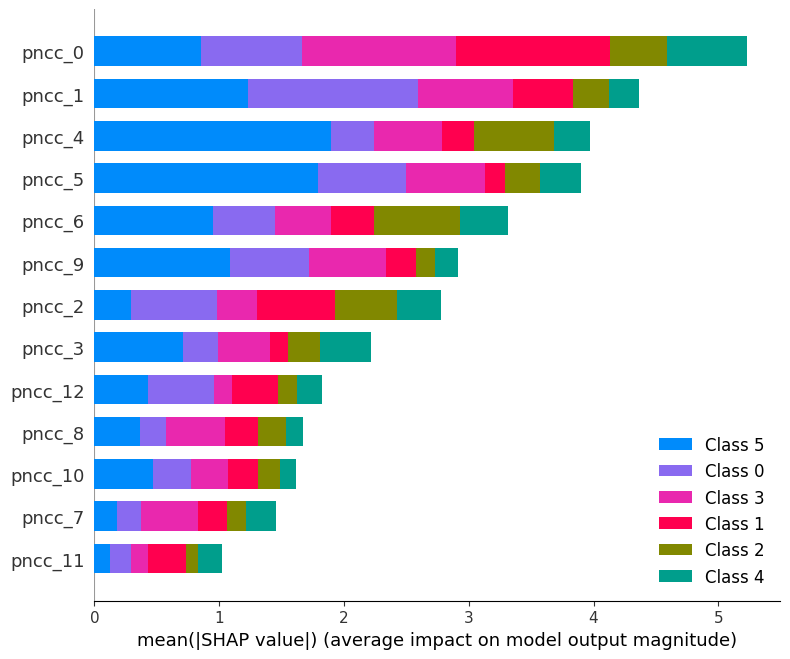

In [ ]:
import shap

# Explain the model's predictions using SHAP by computing SHAP values
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(train_feat_df_pncc)

#Convert the shap values for each class to a single list
shap_as_list=[]
for i in range(6):
    shap_as_list.append(shap_values[:,:,i])

# Plot the SHAP values
shap.summary_plot(shap_as_list, train_feat_df_pncc, plot_type="bar")

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt

confusion_matrix_clean = metrics.confusion_matrix(y_test_clean, model.predict(test_clean_feat_df_pncc))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_clean, display_labels = ['ROC','LES','DCB','PRV','VLD', 'DTA'])
cm_display.plot()
plt.show()

In [ ]:
confusion_matrix_noisy = metrics.confusion_matrix(y_test_noisy, model.predict(test_noisy_feat_df_pncc))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_noisy, display_labels = ['ROC','LES','DCB','PRV','VLD', 'DTA'])
cm_display.plot()
plt.show()